In [1]:
import json
import time
import pandas as pd
from collections import Counter

In [2]:
# Basic data files and paths
TOP_100_PATH = '../data/popular_100_memes.csv'
TOP_100 = pd.read_csv(TOP_100_PATH, encoding = "ISO-8859-1")
DATA_PATH = '../data/memes/'

STATS_PATH = '../data/statistics.json'
with open(STATS_PATH, 'r') as f:
    STATS = json.load(f)
print(TOP_100.head())

          ID                   Name  \
0  112126428   Distracted Boyfriend   
1     438680  Batman Slapping Robin   
2   87743020            Two Buttons   
3  181913649    Drake Hotline Bling   
4      61579    One Does Not Simply   

                                     Alternate Names  
0  distracted bf, guy checking out another girl, ...  
1                                                NaN  
2  2 red buttons, choice button, which button, da...  
3  drakeposting, drakepost, drake hotline approve...  
4  one does not simply walk into morder, lord of ...  


In [3]:
memes_count = Counter(STATS['memes'])
print(len(STATS['memes']))
for f, c in memes_count.most_common():
    print(f, c)

99
Bad-Luck-Brian.json 32141
One-Does-Not-Simply.json 26186
Philosoraptor.json 19971
Boardroom-Meeting-Suggestion.json 18164
Futurama-Fry.json 17325
First-World-Problems.json 17272
The-Most-Interesting-Man-In-The-World.json 15850
Batman-Slapping-Robin.json 14802
Bad-Pun-Dog.json 13194
X-X-Everywhere.json 12985
Expanding-Brain.json 12826
Two-Buttons.json 12232
But-Thats-None-Of-My-Business.json 11097
Ancient-Aliens.json 10555
Creepy-Condescending-Wonka.json 10374
Grumpy-Cat.json 9569
Y-U-No.json 9370
The-Rock-Driving.json 9286
That-Would-Be-Great.json 8600
Waiting-Skeleton.json 8592
Change-My-Mind.json 8563
Leonardo-Dicaprio-Cheers.json 8377
10-Guy.json 8258
Captain-Picard-Facepalm.json 8105
Matrix-Morpheus.json 7833
Third-World-Skeptical-Kid.json 7782
Confession-Bear.json 7778
Am-I-The-Only-One-Around-Here.json 7291
Success-Kid.json 7074
Hide-the-Pain-Harold.json 6973
Roll-Safe-Think-About-It.json 6948
Evil-Toddler.json 6106
Awkward-Moment-Sealion.json 6101
Face-You-Make-Robert-Downey-

In [4]:
selected_memes = [
    'Woman-Yelling-At-Cat.json', 
    'Left-Exit-12-Off-Ramp.json', 
    'Surprised-Pikachu.json',    
    'Is-This-A-Pigeon.json',  
    'Drake-Hotline-Bling.json', 
    'Blank-Nut-Button.json', 
    'One-Does-Not-Simply.json',
    'Change-My-Mind.json', 
    'Roll-Safe-Think-About-It.json', 
    'Leonardo-Dicaprio-Cheers.json' 
]
def open_data(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data

memes_data = []
y = []

for i,meme in enumerate(selected_memes):
    data = open_data(DATA_PATH + meme)
    for d in data:
        if ''.join(d['boxes']).strip() != '':
            memes_data.append(d)
            y.append(i)

In [5]:
print(memes_data[0])
print(len(memes_data))
print(len(y))

{'url': 'https://i.imgflip.com/3z10rd.jpg', 'post': 'https://imgflip.com/i/3z10rd', 'metadata': {'views': '366', 'img-votes': '1', 'title': 'What are you doing me?', 'author': 'mjelliott80'}, 'boxes': ["me: i don't know what to do with my life", "me to me: and i don't want to see it"]}
74152
74152


In [6]:
# Preprocessing data for modelling
from nltk import sent_tokenize, word_tokenize
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [7]:
# functions to preprocess data into a list of words, blocks separated by |
def parse_text(text):
    text = text.lower().strip()
    return word_tokenize(text)

def parse_blocks(blocks):
    result = []
    for i,b in enumerate(blocks):
        result.extend(parse_text(b))
        if i < len(blocks) - 1:
            result.extend('|')
    return result

In [8]:
X_words = [parse_blocks(meme['boxes']) for meme in memes_data]
print(X_words[0])

['me', ':', 'i', 'do', "n't", 'know', 'what', 'to', 'do', 'with', 'my', 'life', '|', 'me', 'to', 'me', ':', 'and', 'i', 'do', "n't", 'want', 'to', 'see', 'it']


In [ ]:
X_sentences = [' '.join(parse_blocks(meme['boxes'])) for meme in memes_data]
print(X_sentences[0])

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_sentences)
scaler = StandardScaler()
X = scaler.fit_transform(X.toarray())

me : i do n't know what to do with my life | me to me : and i do n't want to see it


In [ ]:
clfs = {'lr':LogisticRegression()}
for name, clf in clfs.items():
    scores = cross_val_score(clf, X, y, cv=5)
    print("Model: " + name)
    print("Accuracy for: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [15]:
# RNN building to predict result
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from tqdm.notebook import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [35]:
# making word embeddings for RNN
UNK = "<unk>"
WORDEMBSIZE = 100
W2V_WINDOW = 7
W2V_COUNT = 1
W2V_EPOCH=100

def makeVocab(text):
    vocab = set()
    vocab.add(UNK)
    for sentences in text:
        for word in sentences:
            vocab.add(word)
    return vocab

def makeEmbModel(data):
#     model = FastText(data, size=WORDEMBSIZE, window=3, min_count=1, iter=10, sorted_vocab=1)
    model = Word2Vec(window=W2V_WINDOW, min_count=W2V_COUNT, size=WORDEMBSIZE)
    model.build_vocab(data)
    model.train(data, total_examples=len(data), epochs=W2V_EPOCH)
    print(model)
    return model

def makeEmbeddings(data, model, vocab):
    vecData = []
    for sentence in data:
        wordEmbs = []
        for word in sentence:
            if word in vocab:
#                 print(type(model[word]))
#                 print(model[word])
                wordEmbs.append(model.wv[word])
            else:
                wordEmbs.append(np.zeros(WORDEMBSIZE))
        wordEmbs = torch.FloatTensor(wordEmbs)
        vecData.append(wordEmbs)
    return vecData

In [36]:
# continue making word embeddings
X_words_train, X_words_test, y_train, y_test = train_test_split(X_words, y, train_size=0.8, test_size=0.2, random_state=42)
vocab = makeVocab(X_words_train)
emb_model = makeEmbModel(X_words_train)
vocab = set(list(emb_model.wv.vocab.keys()))
X_train = makeEmbeddings(X_words_train, emb_model, vocab)
X_test = makeEmbeddings(X_words_test, emb_model, vocab)

print(X_words_train[0])
print(X_train[0])
print(y_train[0])

Word2Vec(vocab=34605, size=100, alpha=0.025)
['one', 'does', 'not', 'simply', 'play', 'the', 'sims', 'without', 'embracing', 'their', 'inner', 'psychopath', 'at', 'some', 'point', 'or', 'another']
tensor([[ 0.8799, -2.0651,  0.0299,  ...,  0.7739, -1.4227,  1.0463],
        [-1.2020, -4.0527,  1.7190,  ...,  1.5431, -1.8549,  1.9878],
        [-0.3216, -0.8768, -0.4105,  ...,  0.3146, -1.4686,  0.3993],
        ...,
        [-1.3932,  0.0114,  3.6182,  ...,  3.8677, -0.6427,  1.1640],
        [-2.4189, -3.5808, -2.4173,  ...,  3.6036,  0.5745,  0.4028],
        [-2.6143, -1.7333,  0.6864,  ..., -2.4636, -1.0739, -0.6264]])
6


In [37]:
# RNN model
class RNN(nn.Module):
    def __init__(self, input_dim, h, output_dim = 15):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_dim, h, dropout=0.2)
        self.finalLayer = nn.Linear(h, output_dim)
        self.input_dim = input_dim
        self.hidden_dim = h
        self.output_dim =  output_dim
#         self.word_embeddings = nn.Embedding(vocab_size, input_dim)
        self.softmax = nn.LogSoftmax()
        self.loss = nn.NLLLoss()
    
    def compute_loss(self, predicted_vector, gold_label):
        return self.loss(predicted_vector, gold_label)
    
    def forward(self, inputs):
        out, hidden = self.rnn(inputs)
        hidden = hidden.contiguous().view(-1,self.hidden_dim)
        predicted_vector = self.softmax(self.finalLayer(hidden))
        return predicted_vector
    
class biRNN(nn.Module):
    def __init__(self, input_dim, h, output_dim = 15):
        super(biRNN, self).__init__()
        self.rnn = nn.RNN(input_dim, h, dropout=0.2, bidirectional=True)
        self.finalLayer = nn.Linear(h, output_dim)
        self.input_dim = input_dim
        self.hidden_dim = h
        self.output_dim =  output_dim
#         self.word_embeddings = nn.Embedding(vocab_size, input_dim)
        self.softmax = nn.LogSoftmax()
        self.loss = nn.NLLLoss()
    
    def compute_loss(self, predicted_vector, gold_label):
        return self.loss(predicted_vector, gold_label)
    
    def forward(self, inputs):
        out, hidden = self.rnn(inputs)
        hidden = hidden.contiguous().view(-1,self.hidden_dim)
        predicted_vector = self.softmax(self.finalLayer(hidden))
        return predicted_vector
    
class GRU(nn.Module):
    def __init__(self, input_dim, h, output_dim = 15):
        super(GRU, self).__init__()
        self.rnn = nn.GRU(input_dim, h, dropout=0.2)
        self.finalLayer = nn.Linear(h, output_dim)
        self.input_dim = input_dim
        self.hidden_dim = h
        self.output_dim =  output_dim
#         self.word_embeddings = nn.Embedding(vocab_size, input_dim)
        self.softmax = nn.LogSoftmax()
        self.loss = nn.NLLLoss()
    
    def compute_loss(self, predicted_vector, gold_label):
        return self.loss(predicted_vector, gold_label)
    
    def forward(self, inputs):
        out, hidden = self.rnn(inputs)
        hidden = hidden.contiguous().view(-1,self.hidden_dim)
        predicted_vector = self.softmax(self.finalLayer(hidden))
        return predicted_vector



-------------
EPOCH: 1
Training started for epoch: 1


/Users/ericsun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Training completed for epoch: 1
Time for train: 164.4973030090332
Accuracy: 0.4443507019438445 Loss: 1.6747758388519287
Validation started for epoch: 1



Validation completed for epoch: 1
Time for validation: 15.891801834106445
Accuracy: 0.5274621212121212 Loss: 1.397242784500122


-------------
EPOCH: 2
Training started for epoch: 2



Training completed for epoch: 2
Time for train: 162.89167404174805
Accuracy: 0.5573535367170627 Loss: 1.3060020208358765
Validation started for epoch: 2



Validation completed for epoch: 2
Time for validation: 16.189922094345093
Accuracy: 0.5758252164502164 Loss: 1.2550183534622192


-------------
EPOCH: 3
Training started for epoch: 3



Training completed for epoch: 3
Time for train: 179.29447197914124
Accuracy: 0.5237918466522679 Loss: 1.4193493127822876
Validation started for epoch: 3



Validation completed for epoch: 3
Time for validation: 18.37769103050232
Accuracy: 0.33042478354978355 Loss: 2.055513381958008


-------------
EPOCH: 4
Training started for epoch: 4



Training completed for epoch: 4
Time for train: 170.93320178985596
Accuracy: 0.34479616630669546 Loss: 1.9855263233184814
Validation started for epoch: 4



Validation completed for epoch: 4
Time for validation: 18.517406940460205
Accuracy: 0.36099837662337664 Loss: 1.9367687702178955
Stopping progress: no longer learning for validation


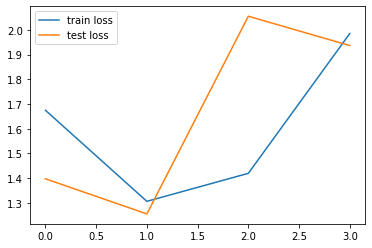

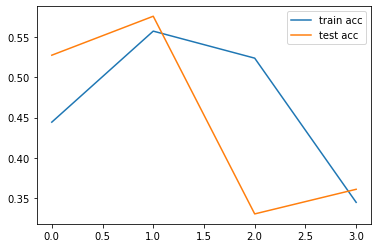

In [38]:
# running epochs for training and validation
HIDDEN_DIM = 124
EPOCHS = 15
minibatch_size = 64

model = RNN(WORDEMBSIZE, HIDDEN_DIM, len(selected_memes))
# model = biRNN(WORDEMBSIZE, HIDDEN_DIM, 15)
# model = GRU(WORDEMBSIZE, HIDDEN_DIM, 15)
optimizer = optim.SGD(model.parameters(),lr=0.01)
train_loss = []
train_acc = []
test_loss = []
test_acc = []
for epoch in range(EPOCHS):
    print("\n\n-------------")
    print("EPOCH: {}".format(epoch + 1))
    running_loss = 0.0
    model.train()
    optimizer.zero_grad()
    print("Training started for epoch: {}".format(epoch + 1))
    X_train, y_train = shuffle(X_train, y_train)
    start_time = time.time()
    correct = total = 0
    N = len(y_train)
    for minibatch_idx in tqdm(range(N // minibatch_size)):
        optimizer.zero_grad()
        loss = None
        for idx in range(minibatch_size):
            text = X_train[minibatch_idx * minibatch_size + idx]
            text = torch.unsqueeze(text, 1)
            labelIdx = y_train[minibatch_idx * minibatch_size + idx]
#             print(X_words_train[minibatch_idx * minibatch_size + idx])
#             print(text.shape)
            log_probs = model(text)
            text_loss = model.compute_loss(log_probs.view(1,-1), torch.tensor([labelIdx]))
            running_loss += text_loss
            if loss is None:
                loss = text_loss
            else:
                loss += text_loss
            pred_label = torch.argmax(log_probs)
            correct += int(pred_label == labelIdx)
            total += 1
        loss = loss / minibatch_size
        loss.backward()
        optimizer.step()
    train_loss.append(running_loss / N)
    train_acc.append(correct / total)
    print("Training completed for epoch: {}".format(epoch + 1))
    print("Time for train: {}".format(time.time() - start_time))
    print("Accuracy: {} Loss: {}".format(correct / total, train_loss[-1]))
    
    #validation
    running_loss = 0.0
    model.eval()
    optimizer.zero_grad()
    print("Validation started for epoch: {}".format(epoch + 1))
    X_test, y_test = shuffle(X_test, y_test)
    start_time = time.time()
    correct = total = 0
    predictions = []
    N = len(y_test)
    for minibatch_idx in tqdm(range(N // minibatch_size)):
        optimizer.zero_grad()
        for idx in range(minibatch_size):
            text = X_test[minibatch_idx * minibatch_size + idx]
            text = torch.unsqueeze(text, 1)
            labelIdx = y_test[minibatch_idx * minibatch_size + idx]
            log_probs = model(text)
            text_loss = model.compute_loss(log_probs.view(1,-1), torch.tensor([labelIdx]))
            running_loss += text_loss
            pred_label = torch.argmax(log_probs)
            correct += int(pred_label == labelIdx)
            total += 1
    curr_loss = running_loss / N
    test_loss.append(curr_loss)
    test_acc.append(correct / total)
    print("Validation completed for epoch: {}".format(epoch + 1))
    print("Time for validation: {}".format(time.time() - start_time))
    print("Accuracy: {} Loss: {}".format(correct / total, curr_loss))
    if len(test_loss) > 3 and curr_loss >= test_loss[-3]:
        print("Stopping progress: no longer learning for validation")
        break

plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.legend()
plt.show()

plt.plot(train_acc, label='train acc')
plt.plot(test_acc, label='test acc')
plt.legend()
plt.show()